In [40]:
import pandas as pd
import numpy as np
data = pd.read_csv("khc01221.txt")

In [41]:
data.head()

,ATT,ADT,ALX,ALY,ARI,APW,APH,AQU,AFX,BTT,BDT,BLX,BLY,BRI,BPW,BPH,BQU,BFX,CNT,MRK
0,0.0000,0.0000,0.2349,0.1531,-1,0.2055,0.1947,1,0.0167,-0.0016,-1.6466,0.3625,-0.0238,-1,0.2552,0.2234,1,0.0166,0,"+,+"""
1,0.0456,45.6178,0.2377,0.1022,-1,0.2315,0.1978,1,0.0623,0.0436,45.2731,0.3630,-0.0154,-1,0.2483,0.2175,1,0.0453,1,""""
2,0.0500,4.3726,0.2624,0.3642,-1,0.2045,0.1318,1,0.0044,0.0485,4.8696,0.3616,0.0083,-1,0.2522,0.2174,1,0.0049,2,""""
3,0.0667,16.7552,0.2513,0.1160,-1,0.2567,0.2101,1,0.0168,0.0651,16.6164,0.3676,0.0187,-1,0.2462,0.2124,1,0.0166,3,""""
4,0.0834,16.6555,0.2566,0.0306,-1,0.2800,0.2289,1,0.0167,0.0818,16.7150,0.3632,0.0060,-1,0.2404,0.2106,1,0.0167,4,""""


In [42]:
def timecut(data):
    temps = pd.DataFrame()
    x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
    y = [0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
    for i in range(0, 16):
        temp = pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]})
        temp = pd.concat([temp.reset_index(), pd.DataFrame( {"x":[x[i]]*temp.shape[0]} ), pd.DataFrame({"y":[y[i]]*temp.shape[0]}) ], axis = 1)
        temps = pd.concat([temps, temp])
    return temps

def timemean(data):
    temps = pd.DataFrame()
    x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
    y = [0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
    for i in range(0, 16):
        temp = pd.DataFrame(pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]}).apply(np.mean)).transpose()
        temp = pd.concat([temp, pd.DataFrame( {"x":[x[i]]*temp.shape[0]} ), pd.DataFrame({"y":[y[i]]*temp.shape[0]}) ], axis = 1)
        temps = pd.concat([temps, temp])
    return temps

def times(data):
    temps = pd.DataFrame()
    x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
    y = [0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
    for i in range(0, 16):
        temp = pd.DataFrame(pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]}).apply(np.mean)).transpose()
        temp = pd.concat([temp, pd.DataFrame(pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]}).apply(np.median)).transpose()])
        temp = pd.concat([temp.reset_index(), pd.DataFrame( {"x":[x[i]]*temp.shape[0]} ),  pd.DataFrame({"y":[y[i]]*temp.shape[0]}) ], axis = 1)
        temps = pd.concat([temps, temp])
    return temps


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

In [44]:
from torch.utils.data import Dataset, DataLoader

class dss(Dataset):
    def __init__(self, a):
        a = timecut(a).iloc[:,1:5]
        self.len = a.shape[0]
        self.x_data = torch.from_numpy(a.iloc[:,0:2].values).float()
        self.y_data = torch.from_numpy(a.iloc[:,2:4].values).float()
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

size = len(data)
indices = list(range(size))
split = int(np.floor(0.3 * size))
np.random.seed(123)
np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]
train_data=data.iloc[train_indices, :]
test_data = data.iloc[test_indices, :]
dstrain = dss(train_data)
dstest = dss(test_data)
trainloader = DataLoader(dataset = dstrain, batch_size = 32, shuffle = True)
testloader = DataLoader(dataset = dstest, batch_size = 32, shuffle = False)

In [45]:
class optim1(nn.Module):
    
    def __init__(self, inputs, outputs):
        super(optim1, self).__init__()
        self.linear1 = torch.nn.Linear(inputs, 20)
        self.linear2 = torch.nn.Linear(20, 20)
        self.linear3 = torch.nn.Linear(20, 20)
        self.linear4 = torch.nn.Linear(20, outputs)
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = self.linear2(h_relu).clamp(min=0)
        h_relu = self.linear3(h_relu).clamp(min=0)
        y_pred = self.linear4(h_relu)
        return y_pred
        

In [46]:
inputs, H, H2,outputs = 2, 30, 10,2
for_graph = []; test_loss = []

model = optim1(inputs, outputs)
criteria = torch.nn.MSELoss(size_average= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for t in range(300):
    for i, datas in enumerate(trainloader):
        In, label = datas
        In, label = V(In), V(label)
        y_pred = model(In)
        loss = criteria(y_pred, label)
        for_graph.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 100 == 99:
            with torch.no_grad():
                for datass in testloader:
                    In, label = datass
                    outputs = model(In)
                    test_loss.append(np.mean((label.numpy() - outputs.numpy())**2))

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [47]:
print(model)

optim1(
  (linear1): Linear(in_features=2, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=20, bias=True)
  (linear4): Linear(in_features=20, out_features=2, bias=True)
)


### 로스 그래프

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

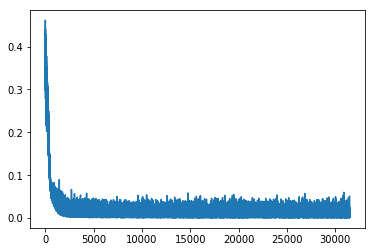

In [49]:
plt.plot(np.arange(len(for_graph)), for_graph)

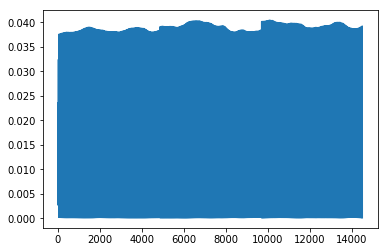

In [50]:
plt.plot(np.arange(len(test_loss)), test_loss)

### 시각화

(-0.1, 1)

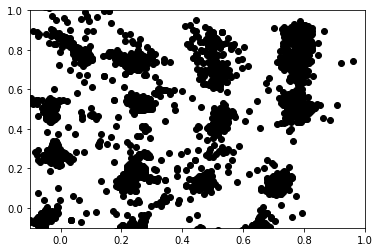

In [51]:
plt.scatter(data.ALX, data.ALY, c = "black");plt.xlim(-0.1,1);plt.ylim(-0.1,1)

In [52]:
out = pd.DataFrame(model(torch.from_numpy(data.iloc[:,2:4].values).float()).detach().numpy())

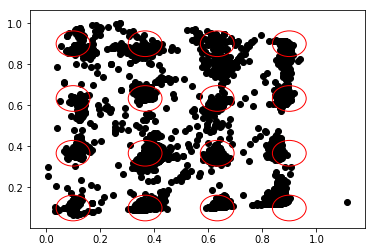

In [53]:
ax = plt.gca()
ax.scatter(out.iloc[:,0], out.iloc[:,1], c= "black")
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)



In [64]:
class optim1(nn.Module):
    
    def __init__(self, inputs, H,outputs):
        super(optim1, self).__init__()
        self.linear1 = torch.nn.Linear(inputs, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, H)
        self.linear5 = torch.nn.Linear(H, outputs)
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = self.linear2(h_relu).clamp(min=0)
        h_relu = self.linear3(h_relu).clamp(min=0)
        h_relu = self.linear4(h_relu).clamp(min=0)
        y_pred = self.linear5(h_relu)
        return y_pred
        

In [70]:
inputs, H, H2,outputs = 2, 10, 10,2
for_graph = []; test_loss = []

model = optim1(inputs,H,outputs)
criteria = torch.nn.MSELoss(size_average= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for t in range(300):
    for i, datas in enumerate(trainloader):
        In, label = datas
        In, label = V(In), V(label)
        y_pred = model(In)
        loss = criteria(y_pred, label)
        for_graph.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 100 == 99:
            with torch.no_grad():
                for datass in testloader:
                    In, label = datass
                    outputs = model(In)
                    test_loss.append(np.mean((label.numpy() - outputs.numpy())**2))

In [71]:
print(model)

optim1(
  (linear1): Linear(in_features=2, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=20, bias=True)
  (linear4): Linear(in_features=20, out_features=20, bias=True)
  (linear5): Linear(in_features=20, out_features=2, bias=True)
)


### 로스 그래프

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

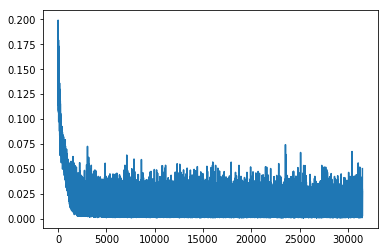

In [73]:
plt.plot(np.arange(len(for_graph)), for_graph)

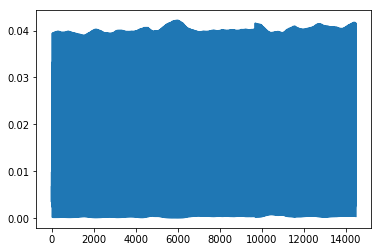

In [74]:
plt.plot(np.arange(len(test_loss)), test_loss)

### 시각화

(-0.1, 1)

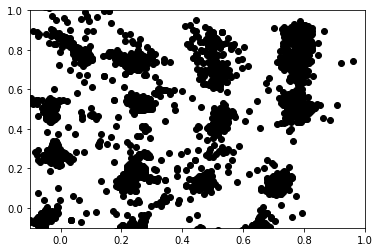

In [75]:
plt.scatter(data.ALX, data.ALY, c = "black");plt.xlim(-0.1,1);plt.ylim(-0.1,1)

In [76]:
out = pd.DataFrame(model(torch.from_numpy(data.iloc[:,2:4].values).float()).detach().numpy())

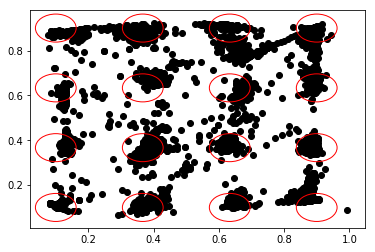

In [77]:
ax = plt.gca()
ax.scatter(out.iloc[:,0], out.iloc[:,1], c= "black")
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)

